# Basic python imports and model settings

In [1]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]

# make it command line compatible
if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 5

i = km_index
i = 0

systemDim = L[i] 

maxZ = maxX = L[i] * 1000.

resX = 50
resY = 25
resZ = 8

resX = 10
resY = 5
resZ = 10

omega = 2.0 * np.pi / maxX
alpha = 0.1 / 180. * np.pi # 0.1 = Experiment C + D, 0.5 = Experiment A + B
amplitude = 500.

surface_height = 1000. + 1000. / (resY-1)

maxY = surface_height

minY = minX = minZ = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

print("resX: " + str(resX) + " resY: " + str(resY) )

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "_res_" + str(resX) + "_x_" + str(resY) + "_x_" + str(resZ) + "/")

if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)
    
delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?

cell_height = maxY / resY
cell_width = maxX / resX
cell_depth = maxZ / resZ

resX: 50 resY: 25


# The mesh

In [2]:

elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY, resZ),
                                minCoord=(minX, minY, minZ),
                                maxCoord=(maxX, maxY, maxZ),
                                periodic=[True, False, True])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
#pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(nodeDofCount=1)

#pressureField.data[:] = 0.
velocityField.data[:] = [0., 0., 0.]

# The swarm

In [3]:
part_per_cell = 500
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# Initialise the 'materialVariable' data to represent different materials.
materialV = 0  	# ice, isotropic
materialB = 1   #

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
#swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

#measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
#pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
#pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
#advector1 = uw.systems.SwarmAdvector(swarm=swarm, velocityField=velocityField, order=2)
#advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm, velocityField=velocityField, order=2)

# Definition of basal friction

In [4]:
coord = fn.input()
beta_square = 1000. + 1000. * fn.math.sin(omega * fn.input()[0]) * fn.math.sin(omega * fn.input()[2]) + 1e-18
#1000. + 1000. * fn.math.sin(omega * fn.input()[0]) + 1e-18

# Set the material for the ice-rock interface

In [5]:
# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = ice_density

coord = fn.input()

#if(coord[1] <= cell_height):  # inside the circle
       # materialVariable.data[:] = materialB
conditions = [(coord[1] > cell_height, materialV),
              (coord[1] <= cell_height, materialB),
              (True, materialV)]       
        
materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)
#pyplot.plot(measurementSwarm.data[:,0], measurementSwarm.data[:,1], color='black')

# Boundary conditions

In [6]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]

# Surface points
top = mesh.specialSets["MaxJ_VertexSet"]

# Basis points
# base = ...
# defined in the mesh_deform_Ind function above

velocityField.data[:] = [1., 0., 0.]

leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']
botSet = mesh.specialSets['Bottom_VertexSet']

# Dirichlet
condition = uw.conditions.DirichletCondition(variable = velocityField, indexSetsPerDof=(botSet, botSet, botSet))

velocityField.data[:] = [0., 0., 0.]

#As = 1. / beta_square
#tau_b = maxY * np.sin(alpha) * 9.81 * 910.
#basalVelocityField = mesh.add_variable(1)
#basalVelocityField.data[:] = tau_b / beta_square.evaluate(mesh.data)

# Strainrate

In [7]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

# Effective viscosity, density and gravity

In [8]:
minViscosityIceFn = fn.misc.constant(1e+8 / 31556926)
maxViscosityIceFn = fn.misc.constant(1e+16 / 31556926)

viscosityFnRock = fn.misc.constant(1e23 / 31556926)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityFnBase = cell_height * beta_square

viscosityMap = {
                materialV: viscosityFnIce,
                materialB: viscosityFnBase,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )
densityFnAir = fn.misc.constant (0.)

densityMap = {
                materialV: densityFnIce,
                materialB: densityFnIce,
             }

densityFn = densityFnIce

surf_inclination = alpha 
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination), 0.)

buoyancyFn = densityFn * z_hat * 9.81

In [9]:
'''
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.append( vis.objects.Points( swarm, materialVariable, pointSize=10.0 ) )
figMesh.save_image("mesh_deform.png")
figMesh.show()
'''

particleViscosity = swarm.add_variable(dataType="double", count=1)
particleViscosity.data[:] = viscosityFn.evaluate(swarm)

# example for 3D
figMaterials = vis.Figure(title="Basis")
#figMaterials.append( vis.objects.Mesh(mesh) )
#figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=4.0, colourBar=True,))
figMaterials.append(vis.objects.Points(swarm, particleViscosity, fn_mask=materialVariable, pointSize=4.0, colourBar=True))
figMaterials.window()

{}

# Stress

In [10]:
devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

# Solver

In [11]:
stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=condition,
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver (stokes)

#solver.set_inner_method ("lu")
#solver.set_inner_method ("superlu")
solver.set_inner_method ("mumps")
#solver.set_inner_method ("superludist")
#solver.set_inner_method ("mg")
#solver.set_inner_method ("nomg")

# solver.set_penalty (1.0e21 / 31556926)  # higher penalty = larger stability

#solver.options.scr.ksp_rtol = 1.0e-3
solver.set_penalty( 1.e6 )
nl_tol = 1.e-2 # standard value

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    exec_time = time.time()
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    #solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    exec_time = time.time() - exec_time
    
    # print full stats to a file
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)
    
print (exec_time)

Calibration pressure 29794.563570146925
Calibration pressure 383942.53650200425
Calibration pressure 540899.7823259962
Calibration pressure 618186.6143874148
Calibration pressure 644791.1386133403
Calibration pressure 663496.4203568965
Calibration pressure 672773.5707234986

 
Pressure iterations: 2756
Velocity iterations:   1 (presolve)      
Velocity iterations: 2847 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations: 2849 (total solve)   
 
SCR RHS  setup time: 4.7667e+00
SCR RHS  solve time: 2.0138e-01
Pressure setup time: 1.6864e-02
Pressure solve time: 2.5771e+02
Velocity setup time: 5.2600e-07 (backsolve)
Velocity solve time: 8.5418e-02 (backsolve)
Total solve time   : 2.6408e+02
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

1292.7318904399872


# Shearstress

Stress is a symmetric tensor, and underword can deal with this in the 'underworld.function.tensor'. Call `help(uw.function.tensor)` to get the description!

A symmetric tensor in underworld is stored as a list:
$$\left[  a_{00}, a_{11}, a_{22}, a_{01}, a_{02}, a_{12}  \right]$$

The elements of the list correspond to the following naming scheme for the elements of a matrix:
$$
         \left[  a_{00}, a_{01}, a_{02}, \\
                        a_{01},     a_{11}, a_{12}, \\
                        a_{02}, a_{12}, a_{22}  \right]
$$

So, if your Stress-function is called 'devStressFn' and returns an underworld-tensor (called $\sigma$ in the following), then you can access the element $a_{22}$ of that tensor by:

    devStressFn.evaluate((x,y,z))[0][2]

(the first [0] is needed, because underworld return a list of lists, see below).

The following line will return the value $\sigma_{11}$, corresponding to $a_{11}$ above:

    devStressFn.evaluate((3000., 1000., 3000.))[0][1]

# Write out surface data

In [ ]:
xpos = np.arange(start=0, stop=int(resX+1)) * maxX / resX
zpos = np.ones(resX+1) * maxZ * 0.25

xz = np.array(np.meshgrid(xpos, zpos)).T.reshape(-1,2)

surf_pos = np.insert(xz, 1, maxY, axis=1 )
base_pos = np.insert(xz, 1, 0., axis=1 )

## New output routine (all points)

/home/jovyan/workspace/output_160000.0_res_50_x_25_x_8/jla1c160.csv
DeltaP


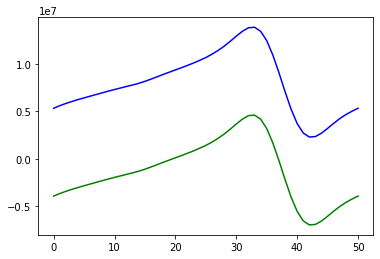

vxs


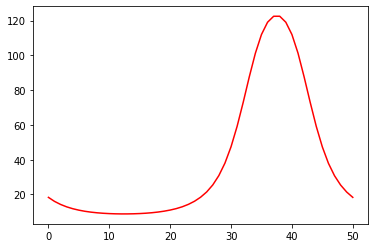

Shear stress


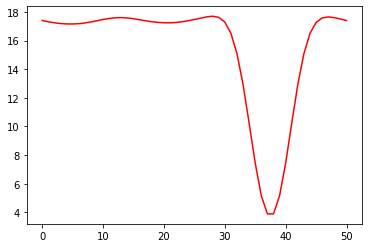

In [48]:
#### Filename
outputFile = os.path.join(os.path.abspath("."), "jla"+"1c"+ str(systemDim).zfill(3) + ".csv")
print(outputFile)

#### Smooth the stress
meshStressTensor = uw.mesh.MeshVariable(mesh, 6)
projectorStress = uw.utils.MeshVariable_Projection( meshStressTensor, devStressFn, type=0 )
projectorStress.solve()

#### Smooth the velocity
meshVelocity = uw.mesh.MeshVariable(mesh, 3)
projectorV = uw.utils.MeshVariable_Projection( meshVelocity, velocityField, type=0 )
projectorV.solve()

#### Smooth the pressure
meshP = uw.mesh.MeshVariable(mesh, 1)
projectorP = uw.utils.MeshVariable_Projection( meshP, pressureField, type=0 )
projectorP.solve()

#### Points
xpos = np.arange(start=0, stop=int(resX+1)) * maxX / resX
zpos = np.arange(start=0, stop=int(resZ+1)) * maxZ / resZ

xz = np.array(np.meshgrid(xpos, zpos)).T.reshape(-1,2)

sub = .1 * cell_height
add = 0. * cell_height

surf_pos = np.insert(xz, 1, maxY - sub, axis=1 )
base_pos = np.insert(xz, 1, 0. + add, axis=1 )

#### Get the surface velocity
#vxs = meshVelocity.evaluate(surf_pos).transpose()[0]
#vys = meshVelocity.evaluate(surf_pos).transpose()[1]
#vzs = meshVelocity.evaluate(surf_pos).transpose()[2]
vxs = velocityField.evaluate(surf_pos).transpose()[0]
vys = velocityField.evaluate(surf_pos).transpose()[1]
vzs = velocityField.evaluate(surf_pos).transpose()[2]

vtots = np.sqrt( vxs*vxs + vys*vys + vzs*vzs )

#### Get the basal velocity
#vxb = meshVelocity.evaluate(base_pos).transpose()[0]
#vyb = meshVelocity.evaluate(base_pos).transpose()[1]
#vzb = meshVelocity.evaluate(base_pos).transpose()[2]
vxb = velocityField.evaluate(base_pos).transpose()[0]
vyb = velocityField.evaluate(base_pos).transpose()[1]
vzb = velocityField.evaluate(base_pos).transpose()[2]

vtotb = np.sqrt( vxb*vxb + vyb*vyb + vzb*vzb )

#### Get the pressure
#P = meshP.evaluate(base_pos).squeeze()
P = pressureField.evaluate(base_pos).squeeze()

#### Get the shearstress
sxz = meshStressTensor.evaluate(base_pos).squeeze()[:,3]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

sxy = meshStressTensor.evaluate(base_pos).squeeze()[:,4]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

#### only indices where z ~ 0.25
ind = np.where(np.logical_and(xz[:,1] > 0.24 * maxZ , xz[:,1] < 0.26 * maxZ))

#### plot pressure from grid / theoretical / difference
print("DeltaP")
#pyplot.plot((maxY - base_ypos[:]) * 9.81 * 910, color='red')
pyplot.plot(P[ind], color='blue')
pyplot.plot( P[ind] - (maxY - base_pos[ind, 1].squeeze()) * 9.81 * 910., color='green')
pyplot.show()

#### plot vx at surface
print("vxs")
pyplot.plot(vxs[ind], color='red')
pyplot.show()

### plot shear stress
print("Shear stress")
pyplot.plot(sxz[ind] / 1000., color='red')
pyplot.show()

#### output to file
with open(outputFile, "w") as text_file:
    
    for i in range(0, resX+1):
        
        # Ausgabe [x] [y]
        textline = str("{:.7f}".format(surf_pos[i, 0] / maxX)) + "\t" \
        + str("{:.7f}".format(surf_pos[i, 2] / maxZ)) + "\t"
        
        #Ausgabe Geschwindigkeiten Surface[vx] [vy] [vz]
        textline += str("{:.7f}".format(vxs[i])) + "\t" + str("{:.7f}".format(vzs[i])) \
        + "\t" + str("{:.7f}".format(vys[i])) + "\t"
        
        #Ausgabe Geschwindigkeiten Basis [vx] [vy]
        textline += str("{:.7f}".format(vxb[i])) + "\t" + str("{:.7f}".format(vzb[i])) + "\t"
        
        # Scherspannung Basis Tensoren [Txz] [Tyz]
        textline += str("{:.7f}".format(sxz[i] / 1000.)) + "\t" + str("{:.7f}".format(sxy[i] / 1000.)) + "\t"
        
        # Ausgabe delta p
        textline += str("{:.7f}".format(float(P[i]) - float((maxY - base_pos[i, 1]) * 9.81 * 910 / 1000))) + "\n"

        text_file.write(textline)
        

## old output routine (usually to be commented out)

/home/jovyan/workspace/output_160000.0_res_50_x_25_x_8/jla1c160.csv
DeltaP


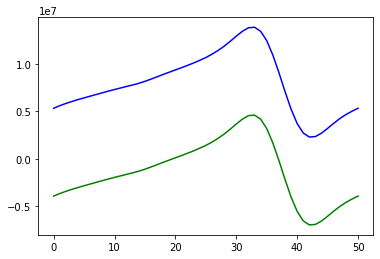

vxs


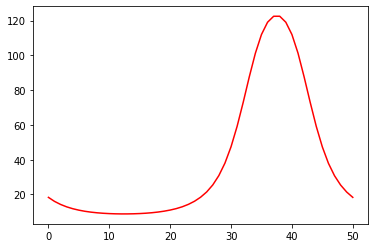

Shear stress


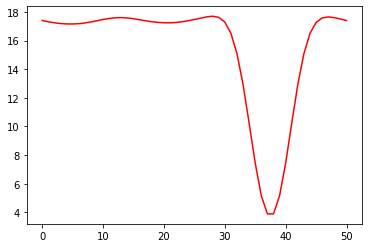

In [16]:
'''
#### Filename
outputFile = os.path.join(os.path.abspath("."), "jla"+"1c"+ str(systemDim).zfill(3) + ".csv")
print(outputFile)

#### Smooth the stress
meshStressTensor = uw.mesh.MeshVariable(mesh, 6)
projectorStress = uw.utils.MeshVariable_Projection( meshStressTensor, devStressFn, type=0 )
projectorStress.solve()

#### Smooth the velocity
meshVelocity = uw.mesh.MeshVariable(mesh, 3)
projectorV = uw.utils.MeshVariable_Projection( meshVelocity, velocityField, type=0 )
projectorV.solve()

#### Smooth the pressure
meshP = uw.mesh.MeshVariable(mesh, 1)
projectorP = uw.utils.MeshVariable_Projection( meshP, pressureField, type=0 )
projectorP.solve()

#### Points
surf_xpos = base_xpos = np.arange(start=0, stop=int(resX+1)) * maxX / resX
surf_zpos = base_zpos = np.ones(resX+1) * maxZ * 0.25

base_ypos = np.zeros(resX+1)
surf_ypos = np.ones(resX+1) * maxY

base_ypos += 0. * cell_height
surf_ypos -= .1 * cell_height

base_pos = np.column_stack( (base_xpos, base_ypos, base_zpos) )
surf_pos = np.column_stack( (surf_xpos, surf_ypos, surf_zpos) )

#### Get the surface velocity
#vxs = meshVelocity.evaluate(surf_pos).transpose()[0]
#vys = meshVelocity.evaluate(surf_pos).transpose()[1]
#vzs = meshVelocity.evaluate(surf_pos).transpose()[2]
vxs = velocityField.evaluate(surf_pos).transpose()[0]
vys = velocityField.evaluate(surf_pos).transpose()[1]
vzs = velocityField.evaluate(surf_pos).transpose()[2]

vtots = np.sqrt( vxs*vxs + vys*vys + vzs*vzs )

#### Get the basal velocity
#vxb = meshVelocity.evaluate(base_pos).transpose()[0]
#vyb = meshVelocity.evaluate(base_pos).transpose()[1]
#vzb = meshVelocity.evaluate(base_pos).transpose()[2]
vxb = velocityField.evaluate(base_pos).transpose()[0]
vyb = velocityField.evaluate(base_pos).transpose()[1]
vzb = velocityField.evaluate(base_pos).transpose()[2]

vtotb = np.sqrt( vxb*vxb + vyb*vyb + vzb*vzb )

#### Get the pressure
#P = meshP.evaluate(base_pos).squeeze()
P = pressureField.evaluate(base_pos).squeeze()

#### Get the shearstress
sxz = meshStressTensor.evaluate(base_pos).squeeze()[:,3]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

sxy = meshStressTensor.evaluate(base_pos).squeeze()[:,4]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

#### plot pressure from grid / theoretical / difference
print("DeltaP")
#pyplot.plot((maxY - base_ypos[:]) * 9.81 * 910, color='red')
pyplot.plot(P, color='blue')
pyplot.plot( P - (maxY - base_ypos) * 9.81 * 910., color='green')
pyplot.show()

#### plot vx at surface
print("vxs")
pyplot.plot(vxs, color='red')
pyplot.show()

### plot shear stress
print("Shear stress")
pyplot.plot(sxz / 1000., color='red')
pyplot.show()

#### output to file
with open(outputFile, "w") as text_file:
    
    for i in range(0, resX+1):
        
        # Ausgabe [x] [y]
        textline = str("{:.7f}".format(surf_pos[i, 0] / maxX)) + "\t" \
        + str("{:.7f}".format(surf_pos[i, 2] / maxZ)) + "\t"
        
        #Ausgabe Geschwindigkeiten Surface[vx] [vy] [vz]
        textline += str("{:.7f}".format(vxs[i])) + "\t" + str("{:.7f}".format(vzs[i])) \
        + "\t" + str("{:.7f}".format(vys[i])) + "\t"
        
        #Ausgabe Geschwindigkeiten Basis [vx] [vy]
        textline += str("{:.7f}".format(vxb[i])) + "\t" + str("{:.7f}".format(vzb[i])) + "\t"
        
        # Scherspannung Basis Tensoren [Txz] [Tyz]
        textline += str("{:.7f}".format(sxz[i] / 1000.)) + "\t" + str("{:.7f}".format(sxy[i] / 1000.)) + "\t"
        
        # Ausgabe delta p
        textline += str("{:.7f}".format(float(P[i]) - float((maxY - base_pos[i, 1]) * 9.81 * 910 / 1000))) + "\n"

        text_file.write(textline)
'''